In [1]:
# Add the parent directory of the current working directory to the Python path at runtime. 
# In order to import modules from the src directory.
import os
import sys
import openai

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

BASEPATH = os.environ["BASEPATH"]
openai.api_key = os.environ["OPENAI_API_KEY"]

In [2]:
import tomllib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers.json import SimpleJsonOutputParser

from src.utils.plotting import convert_size
from src.utils.semantic import safe_dictionary_extraction

sns.set_context("paper")

In [3]:
def parse_directories():
    """
    Parse the directories from the configuration file.
    Returns:
    - directories: dict
    """
    with open('../config/directories.toml', 'rb') as f:
        configurations = tomllib.load(f)

    return configurations

def compute_normalized_annual_growth(data):
    """
    Compute the size-adjusted annual growth rate of each cluster.

    Parameters:
    - data: pd.DataFrame

    Returns:
    - normalized_growth: pd.Series
    """
    cluster_count_per_year = data.groupby(['Year', 'Cluster ID']).size().unstack().fillna(0)

    # compute growth using regression per cluster
    beta = cluster_count_per_year.apply(
        lambda x: pd.Series(
            np.polyfit(cluster_count_per_year.index, x, 1), index=['Slope', 'Intercept']), axis=0)

    # compute normalized growth
    normalized_growth = beta.loc['Slope'] / cluster_count_per_year.sum()

    return normalized_growth

In [4]:
directories = parse_directories()
csv_path = os.path.join(BASEPATH, directories['internal']['intermediate']['csv'],'Psychology')
article_file = os.path.join(BASEPATH, csv_path, "articles_merged_cleaned_filtered_clustered.csv")
cluster_file = os.path.join(BASEPATH, csv_path, "clusters_defined_distinguished_trends.csv")
article_df = pd.read_csv(article_file)
cluster_df = pd.read_csv(cluster_file)

figure_path = os.path.join(BASEPATH, directories['internal']['manuscript']['figures'], 'Figure_04')
os.makedirs(figure_path, exist_ok=True)

tables_path = os.path.join(BASEPATH, directories['internal']['manuscript']['tables'])
os.makedirs(tables_path, exist_ok=True)

In [5]:
# Separate the articles into research and review articles.
research_df = article_df[article_df["Type"] == "Research"]
review_df = article_df[article_df["Type"] == "Review"]

In [6]:
# Compute the normalized annual growth of neuroscience
article_count_per_year = article_df.groupby('Year').size()
beta = pd.Series(np.polyfit(article_count_per_year.index, article_count_per_year.values, 1), index=['Slope', 'Intercept'])
normalized_annual_growth_neuroscience = beta['Slope'] / article_count_per_year.sum()

# Compute the normalized growth of the clusters
normalized_growth = compute_normalized_annual_growth(article_df)

normalized_annual_growth_growing = normalized_growth[normalized_growth > normalized_annual_growth_neuroscience]
normalized_annual_growth_declining = normalized_growth[normalized_growth < 0]
normalized_annual_growth_stable = normalized_growth[(normalized_growth >= 0) & (normalized_growth <= normalized_annual_growth_neuroscience)]

### Figure 3 Panels

In [7]:
# Define the panel size (width, height) in centimeters
figure_size = [89, 89]

# Convert the panel size to inches
figure_size_inch = convert_size(*figure_size)

# Define the color palette
colormap_all = sns.color_palette('Spectral', 30)
growth_colors = ['#648fff', '#dc267f', '#ffb000']

# Define hue order
growth_hue_order = ['Growing', 'Declining', 'Stable']

# Define the font sizes
fontsize_text = 6
fontsize_ticks = 5

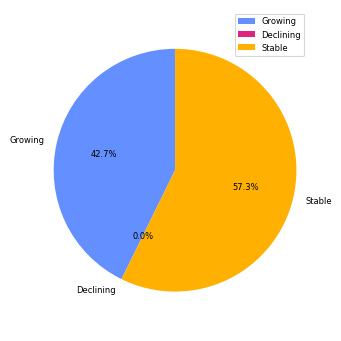

In [8]:
# Panel A: Pie chart showing the distribution of growing, declining, and stable clusters

# Define the data
num_growing = len(normalized_annual_growth_growing)
num_declining = len(normalized_annual_growth_declining)
num_stable = len(normalized_annual_growth_stable)

growth_counts = pd.Series([num_growing, num_declining, num_stable], index=['Growing', 'Declining', 'Stable'])

# Define the figure
plt.figure(figsize=figure_size_inch)
plt.pie(growth_counts, labels=growth_counts.index, autopct='%1.1f%%', colors=growth_colors, startangle=90, textprops={'fontsize': fontsize_text})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


# Set legend with correct font size and without title
plt.legend(title=None, fontsize=fontsize_text)

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'panel_a.svg'), format='svg')
plt.show()

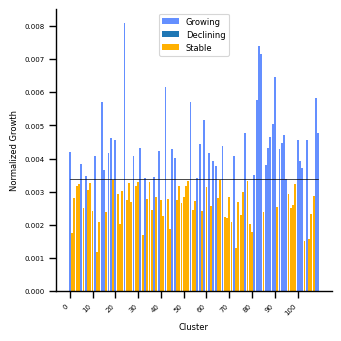

In [9]:
# Panel B: Bar chart of the growth rate of the clusters
label_interval = 10

# plot the growth rate of the clusters
plt.figure(figsize=figure_size_inch)

plt.bar(
    normalized_annual_growth_growing.index,
    normalized_annual_growth_growing,
    color=growth_colors[0],
    label='Growing',
)

plt.bar(
    normalized_annual_growth_declining.index,
    normalized_annual_growth_declining,
    color=growth_colors[1],
    label='Declining',
)

plt.bar(
    normalized_annual_growth_stable.index,
    normalized_annual_growth_stable,
    color=growth_colors[2],
    label='Stable',
)

plt.plot(range(len(normalized_growth)), [normalized_annual_growth_neuroscience] * len(normalized_growth), color='black', linewidth=0.5)

sns.despine()

plt.xticks(
    ticks=range(0, len(normalized_growth), label_interval),
    rotation=45,
    ha='right',
    fontsize=fontsize_ticks
)

# Set y-ticks font size
plt.yticks(fontsize=fontsize_ticks)

# Set axis labels with correct font size
plt.xlabel('Cluster', fontsize=fontsize_text)
plt.ylabel('Normalized Growth', fontsize=fontsize_text)

# Set legend with correct font size and without title
plt.legend(title=None, fontsize=fontsize_text)

plt.tight_layout()

plt.savefig(os.path.join(figure_path, 'panel_b.svg'), format='svg')
plt.show()



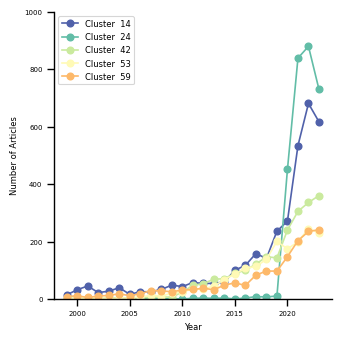

In [20]:
# Panel C: Line plot showing sizes of the 5 most growing clusters per year

# Select the colors for the line plot
colormap = colormap_all[-1::-5]

# Select the 10 most growing clusters
top_clusters = sorted(normalized_annual_growth_growing.sort_values(ascending=False).head(10).index)

# Select the data for the 5 most growing clusters
top_clusters_data = article_df[article_df['Cluster ID'].isin(top_clusters)]

# Compute the size of the 5 most growing clusters per year
top_clusters_size = top_clusters_data.groupby(['Year', 'Cluster ID']).size().unstack().fillna(0)

plt.figure(figsize=figure_size_inch)

for i, cluster in enumerate(top_clusters[:5]):
    plt.plot(
        top_clusters_size.index,
        top_clusters_size[cluster],
        color=colormap[i],
        label=f'Cluster {cluster:3d}',
        marker='o',
    )

sns.despine()
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel('Year', fontsize=fontsize_text)
plt.ylabel('Number of Articles', fontsize=fontsize_text)
plt.ylim(0, 1000)
plt.legend(title=None, fontsize=fontsize_text)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'panel_c.svg'), format='svg')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


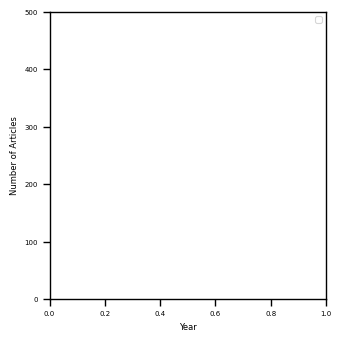

In [11]:
# Panel D: Line plot showing sizes of the 5 most declining clusters per year

# Select the colors for the line plot
colormap = colormap_all[:10]

# Select the 5 most declining clusters
top_clusters = sorted(normalized_annual_growth_declining.sort_values(ascending=True).head(10).index)

# Select the data for the 5 most declining clusters
top_clusters_data = article_df[article_df['Cluster ID'].isin(top_clusters)]

# Compute the size of the 5 most declining clusters per year
top_clusters_size = top_clusters_data.groupby(['Year', 'Cluster ID']).size().unstack().fillna(0)

plt.figure(figsize=figure_size_inch)

for i, cluster in enumerate(top_clusters):
    plt.plot(
        top_clusters_size.index,
        top_clusters_size[cluster],
        color=colormap[i],
        label=f'Cluster {cluster:3d}',
    )

sns.despine()
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel('Year', fontsize=fontsize_text)
plt.ylabel('Number of Articles', fontsize=fontsize_text)
plt.ylim(0, 500)
plt.legend(title=None, fontsize=fontsize_text)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'panel_d.svg'), format='svg')
plt.show()

### Aggregate cluster-specific trends and open questions into discipline-wide trends

In [12]:
temperature = 1.0
model_name = 'gpt-4o-2024-08-06'
delay = 0.2
retries = 10

# Define the required keys for the output dictionary
trends_keys = [
                'Overarching Trend 1', 'Overarching Trend 2', 'Overarching Trend 3',
                'Overarching Trend 4', 'Overarching Trend 5', 'Overarching Trend 6',
                'Overarching Trend 7', 'Overarching Trend 8', 'Overarching Trend 9',
                'Overarching Trend 10']

necessary_keys = [
                'Necessary Development 1', 'Necessary Development 2', 'Necessary Development 3',
                'Necessary Development 4', 'Necessary Development 5', 'Necessary Development 6',
                'Necessary Development 7', 'Necessary Development 8', 'Necessary Development 9',
                'Necessary Development 10']

questions_keys = [
                'Transcendental Question 1', 'Transcendental Question 2', 'Transcendental Question 3',
                'Transcendental Question 4', 'Transcendental Question 5', 'Transcendental Question 6',
                'Transcendental Question 7', 'Transcendental Question 8', 'Transcendental Question 9',
                'Transcendental Question 10']

In [13]:
# Deine prompt temlates
TRENDS_PROMPT = PromptTemplate(
    input_variables=["text", "type"],
    template="""
            You are an expert in neuroscience and scientific text analysis. 
            You are provided with a set of emerging trends and open questions in specific neuroscience clusters.
            
            Your task is to analyze the trends and questions in the clusters and provide an overview of the 10 {type}s that transcend the clusters and reflect the current state of neuroscience as a whole.
            Any {type} may focus on thematic developments, methodological developments, or both. For trends both negative and positive developments can be interesting, but necessary developments should focus on which shortcomings need to be addressed.

            Provide your analysis in a structured JSON format.

            **Output Format:**

            Please present your findings in **JSON format** with the following structure:
            {{
                "{type} 1": Brief assessment and description of the first {type},
                "{type} 2": Brief assessment and description of the second {type},
                "{type} 3": Brief assessment and description of the third {type},
                "{type} 4": Brief assessment and description of the fourth {type},
                "{type} 5": Brief assessment and description of the fifth {type},
                "{type} 6": Brief assessment and description of the sixth {type},
                "{type} 7": Brief assessment and description of the seventh {type},
                "{type} 8": Brief assessment and description of the eighth {type},
                "{type} 9": Brief assessment and description of the ninth {type},
                "{type} 10": Brief assessment and description of the tenth {type}
            }}

            **Instructions:**
            - **Importance**: Focus on the most important {type}s that are relevant to the field of neuroscience as a whole.
            - **Big Picture View**: {type}s that only apply to a single or very small number of cluster should not be included. Focus on {type}s that transcend the clusters and reflect the broader field of neuroscience. A {type} that is relevant to many clusters, though not necessarily all, should be included.
            - **Accuracy is crucial**: Ensure all information is directly supported by the provided text. Do not include information not present in the text or make external assumptions.
            - **Clarity and Precision**: Assessments and descriptions should be clear and accurately reflect the content of the text.
            - **Conciseness**: Do not include any additional text or explanations beyond the specified JSON output. Do not generate more output than necessary.

            **Here are the cluster specific trends and open questions**:
            {text}
            """,
)

In [14]:
# Define the LLM chain
llm = ChatOpenAI(temperature=temperature, model=model_name)
trends_chain = TRENDS_PROMPT | llm | SimpleJsonOutputParser()

In [35]:
keys = ['Emerging Themes', 'Emerging Methodological Approaches', 'Declining Themes', 'Declining Methodological Approaches']

trends_dict = {key: [] for key in keys}
trends_dict['Cluster ID'] = []
trends_dict['Open Questions'] = []

trends_list = []

for row in cluster_df.iterrows():
    cluster = row[1]
    trends_dict['Cluster ID'].append(cluster['Cluster ID'])
    trends_dict['Open Questions'].append(cluster['Open Questions'])

    trends_list.append(f'Cluster {cluster['Cluster ID']}')
    trends_list.append(cluster['Trends'])
    trends_list.append(cluster['Open Questions'])

    for key in keys:
        all_text = cluster['Trends']
        key_text = all_text.split(key)[1].split(': ')[1].split('\n')[0]
        trends_dict[key].append(key_text)

trends_text = '\n'.join(trends_list)

trends_df = pd.DataFrame(trends_dict)
trends_df = trends_df[['Cluster ID'] + keys + ['Open Questions']]
trends_df.to_csv(os.path.join(tables_path, 'supplementary_table_04.csv'), index=False)

# Save as supplementary table (excel)
trends_df.to_excel(os.path.join(tables_path, 'supplementary_table_04.xlsx'), index=False)

In [32]:
global_trends_file = os.path.join(tables_path,'table_01', 'global_trends.csv')
os.makedirs(os.path.dirname(global_trends_file), exist_ok=True)

if os.path.exists(global_trends_file):
    print("Loading global trends from file")
    global_trends_df = pd.read_csv(global_trends_file)
else:
    chain_input = {
        'text': trends_text,
        'type': 'Overarching Trend'
    }
    global_trends = safe_dictionary_extraction(trends_keys, chain_input, trends_chain, retries, delay)
    global_trends_df = pd.DataFrame(global_trends, index=[0])
    global_trends_df.to_csv(global_trends_file, index=False)

Loading global trends from file


In [33]:
global_questions_file = os.path.join(tables_path, 'table_01', 'global_questions.csv')
if os.path.exists(global_questions_file):
    print('Loading global questions from file')
    global_questions_df = pd.read_csv(global_questions_file)
else:
    chain_input = {
        'text': trends_text,
        'type': 'Transcendental Question'
    }
    global_questions = safe_dictionary_extraction(questions_keys, chain_input, trends_chain, retries, delay)
    global_questions_df = pd.DataFrame(global_questions, index=[0])
    global_questions_df.to_csv(global_questions_file, index=False)

Loading global questions from file


In [34]:
necessary_developments_file = os.path.join(tables_path, 'table_01', 'necessary_developments.csv')
if os.path.exists(necessary_developments_file):
    print("Loading necessary developments from file")
    necessary_developments_df = pd.read_csv(necessary_developments_file)
else:
    chain_input = {
        'text': trends_text,
        'type': 'Necessary Development'
    }
    necessary_developments = safe_dictionary_extraction(necessary_keys, chain_input, trends_chain, retries, delay)
    necessary_developments_df = pd.DataFrame(necessary_developments, index=[0])
    necessary_developments_df.to_csv(necessary_developments_file, index=False)

Loading necessary developments from file
